# Main Parsing

In [ ]:
!pip install -q demoparser2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 16.3 MB/s eta 0:00:00


In [ ]:
parser.list_game_events()

In [ ]:
from demoparser2 import DemoParser
from uuid import uuid4
import numpy as np

parser = DemoParser("/content/drive/MyDrive/DemoAI/test_demo.dem")
event_df = parser.parse_event("player_death", player=["X", "Y"], other=["total_rounds_played"])
info = parser.parse_header()
tick_df = parser.parse_ticks(
    ["X", "Y", "Z", "start_balance", "balance", "total_rounds_played", "is_match_started", "is_freeze_period", "round_in_progress", "game_time", "is_alive", "is_warmup_period", "team_name"]
)
tick_df['map_name'] = info['map_name']
tick_df['game_name'] = uuid4()
# разница с предыдущей точкой
tick_df['dx'] = tick_df['X'].diff()
tick_df['dy'] = tick_df['Y'].diff()

# длина вектора (модуль)
length = np.sqrt(tick_df['dx']**2 + tick_df['dy']**2)

# единичный вектор (normalized)
tick_df['dir_vec_x'] = tick_df['dx'] / length
tick_df['dir_vec_y'] = tick_df['dy'] / length

# для первой строки будет NaN, можно заменить на (0,0)
tick_df[['dir_vec_x', 'dir_vec_y']] = tick_df[['dir_vec_x', 'dir_vec_y']].fillna(0)

In [ ]:
event_df.columns

Index(['assistedflash', 'assister_X', 'assister_Y', 'assister_name',
       'assister_steamid', 'attacker_X', 'attacker_Y', 'attacker_name',
       'attacker_steamid', 'attackerblind', 'attackerinair', 'distance',
       'dmg_armor', 'dmg_health', 'dominated', 'headshot', 'hitgroup',
       'noreplay', 'noscope', 'penetrated', 'revenge', 'thrusmoke', 'tick',
       'total_rounds_played', 'user_X', 'user_Y', 'user_name', 'user_steamid',
       'weapon', 'weapon_fauxitemid', 'weapon_itemid',
       'weapon_originalowner_xuid', 'wipe'],
      dtype='object')

In [ ]:
tick_df.columns

Index(['is_freeze_period', 'round_start_time', 'total_rounds_played',
       'is_match_started', 'round_in_progress', 'balance', 'start_balance',
       'X', 'Y', 'Z', 'tick', 'steamid', 'name'],
      dtype='object')

In [ ]:
my_mick = 'AbobaValeriy'
unique_ticks = tick_df.copy()
unique_ticks['game_time'] = unique_ticks['game_time'].apply(int)

# IF FACEIT WE SHOULD SHIFT ROUNDS by 4
unique_ticks["round_num"] = unique_ticks["total_rounds_played"] + 4

round_balances = (
    unique_ticks.groupby(["game_time", "round_num", "name", "steamid", "game_name", "map_name"])
    .agg({
        "team_name": "last",
        "dir_vec_x": "last", "dir_vec_y": "last",
        "is_warmup_period": "last",
        "is_alive": "last",
        "start_balance": "last",
        "balance": "last",
        "X": "last", "Y": "last", "Z": "last",
        "is_freeze_period": "last", "is_match_started": "last"
    }).reset_index()
)

round_balances

,game_time,round_num,name,steamid,game_name,map_name,team_name,dir_vec_x,dir_vec_y,is_warmup_period,is_alive,start_balance,balance,X,Y,Z,is_freeze_period,is_match_started
0,187,4,AbobaValeriy,76561199366282340,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,TERRORIST,-0.707084,-0.707129,False,True,0,0,-1662.180054,288.761993,-63.968750,True,True
1,187,4,Cimeto,76561197971275786,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,CT,0.971782,0.235882,False,True,0,0,2472.349854,2005.969971,134.505051,True,True
2,187,4,MONEYOVRBCHS,76561198055323202,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,CT,0.921829,0.387596,False,True,0,0,2353.000000,1977.000000,135.518875,True,True
3,187,4,adzuka,76561198055571210,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,CT,-0.104859,0.994487,False,True,0,0,2456.830078,2153.159912,132.077179,True,True
4,187,4,chiij,76561199400203970,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,TERRORIST,0.996616,0.082202,False,True,0,0,-1520.060059,430.890991,-63.968750,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27885,2951,26,dADOXYZ,76561198027887817,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,TERRORIST,0.696341,-0.717711,False,False,9200,12450,612.450378,2439.178467,241.031250,True,False
27886,2951,26,lqura,76561198213279155,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,CT,0.492538,0.870291,False,False,50,3450,1100.727783,2674.100830,132.349274,True,False
27887,2951,26,sta1evarov,76561199249362996,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,CT,0.118778,0.992921,False,False,0,3400,281.744751,2780.032715,184.299759,True,False
27888,2951,26,testicles1,76561198405927232,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,TERRORIST,0.088201,0.996103,False,False,6800,10650,659.059082,2965.558594,144.445343,True,False


#Final Simple Dataset Creation

In [ ]:
final_dataset = round_balances[(round_balances['is_freeze_period'] == False) & (round_balances['is_alive']) & (round_balances['start_balance'] > 0) & (round_balances['is_warmup_period'] == False)].reset_index(drop=True)

# final_dataset.to_csv(f"{final_dataset['game_name'].iloc[0]}.csv")

In [ ]:
sequences = []
from IPython.display import display
for (player_name, game_name), group in final_dataset.groupby(['name', 'game_name']):
    group = group.sort_values(['round_num', 'game_time'])
    t_seq = group[group['team_name'] == 'TERRORIST']
    ct_seq = group[group['team_name'] == 'CT']
    display(t_seq.head())
    print(f"TOTAL LENGTH, {len(t_seq)=} {len(ct_seq)=}")
    break

,game_time,round_num,name,steamid,game_name,map_name,team_name,dir_vec_x,dir_vec_y,is_warmup_period,is_alive,start_balance,balance,X,Y,Z,is_freeze_period,is_match_started
0,262,4,AbobaValeriy,76561199366282340,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,TERRORIST,-0.707084,-0.707129,False,True,500,200,-1662.180054,288.761993,-63.96875,False,True
9,263,4,AbobaValeriy,76561199366282340,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,TERRORIST,-0.533293,-0.845930,False,True,500,200,-1615.334839,279.762451,-63.96875,False,True
18,264,4,AbobaValeriy,76561199366282340,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,TERRORIST,0.467806,-0.883831,False,True,500,200,-1405.148071,183.407883,-63.96875,False,True
27,265,4,AbobaValeriy,76561199366282340,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,TERRORIST,0.285676,0.958326,False,True,500,200,-1264.673340,324.729523,-63.96875,False,True
36,266,4,AbobaValeriy,76561199366282340,85b2906f-0c54-4a38-87e4-f1880ada2701,de_inferno,TERRORIST,0.871432,0.490516,False,True,500,200,-1153.285278,508.046448,-61.96875,False,True


TOTAL LENGTH, len(t_seq)=509 len(ct_seq)=593


In [2]:
import os
from demoparser2 import DemoParser
import numpy as np
import pandas as pd
import tqdm

def get_final_demo_dataset(demo_path):
    parser = DemoParser(demo_path)
    info = parser.parse_header()
    tick_df = parser.parse_ticks(
        ["X", "Y", "Z", "start_balance", "balance", "total_rounds_played", "is_match_started",
         "is_freeze_period", "round_in_progress", "game_time", "is_alive", "is_warmup_period", "team_name"]
    )
    tick_df['map_name'] = info['map_name']
    tick_df['game_name'] = os.path.basename(demo_path).split('.')[0]

    # разница с предыдущей точкой
    tick_df['dx'] = tick_df['X'].diff()
    tick_df['dy'] = tick_df['Y'].diff()

    # длина вектора (модуль)
    length = np.sqrt(tick_df['dx']**2 + tick_df['dy']**2)

    # единичный вектор (normalized)
    tick_df['dir_vec_x'] = tick_df['dx'] / length
    tick_df['dir_vec_y'] = tick_df['dy'] / length

    # для первой строки будет NaN → (0,0)
    tick_df[['dir_vec_x', 'dir_vec_y']] = tick_df[['dir_vec_x', 'dir_vec_y']].fillna(0)
    unique_ticks = tick_df.copy()
    unique_ticks['game_time'] = unique_ticks['game_time'].apply(int)

    # IF FACEIT WE SHOULD SHIFT ROUNDS by 4
    unique_ticks["round_num"] = unique_ticks["total_rounds_played"] + 4

    round_balances = (
        unique_ticks.groupby(["game_time", "round_num", "name", "steamid", "game_name", "map_name"])
        .agg({
            "team_name": "last",
            "dir_vec_x": "last", "dir_vec_y": "last",
            "is_warmup_period": "last",
            "is_alive": "last",
            "start_balance": "last",
            "balance": "last",
            "X": "last", "Y": "last", "Z": "last",
            "is_freeze_period": "last", "is_match_started": "last"
        }).reset_index()
    )

    final_dataset = round_balances[
        (round_balances['is_freeze_period'] == False) &
        (round_balances['is_alive']) &
        (round_balances['start_balance'] > 0) &
        (round_balances['is_warmup_period'] == False)
    ].reset_index(drop=True)

    return final_dataset


# путь с демками
demo_dir = '/content/drive/MyDrive/DemoAI/Demos'
demos = os.listdir(demo_dir)

# собираем все датасеты
datasets = []
for demo_file in tqdm.tqdm(demos):
    demo_path = os.path.join(demo_dir, demo_file)
    try:
        df = get_final_demo_dataset(demo_path)
        datasets.append(df)
    except Exception as e:
        print(f"Ошибка при обработке {demo_file}: {e}")

# конкатенация
if datasets:
    final_dataset_concatenated = pd.concat(datasets, ignore_index=True)
    final_dataset_concatenated.to_parquet("final_dataset_updated.parquet")
    print("Финальный датасет сохранён:", final_dataset_concatenated.shape)
else:
    print("Не удалось собрать ни одного датасета.")

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '/content/drive/MyDrive/DemoAI/Demos'

In [ ]:
final_dataset_concatenated.shape

(853668, 17)

# Dataloader creation

## Data loading with context

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from tqdm import tqdm

class CustomPositionsDataset(Dataset):
    def __init__(self, parquet_path="final_dataset_updated.parquet", context_size=128):
        print("Загружаем данные...")
        self.df = pd.read_parquet(parquet_path)
        self.context_size = context_size

        # Сортируем данные
        self.df = self.df.sort_values(['game_name', 'round_num', 'game_time']).reset_index(drop=True)

        # Создаем маппинги
        self.map_to_i = {m: i for i, m in enumerate(self.df['map_name'].unique())}
        self.i_to_map = {i: m for m, i in self.map_to_i.items()}
        self.team_to_i = {t: i for i, t in enumerate(self.df['team_name'].unique())}
        self.i_to_team = {i: t for t, i in self.team_to_i.items()}

        print("==========METADATA============")
        print("Teams:", self.team_to_i)
        print("==============================")
        print("Maps:", self.map_to_i)
        print("==============================")

        # Применяем маппинги
        self.df['team_id'] = self.df['team_name'].map(self.team_to_i)
        self.df['map_id'] = self.df['map_name'].map(self.map_to_i)

        # Определяем колонки
        self.feature_cols = ['map_id', 'round_num', 'team_id', 'X', 'Y', 'dir_vec_x', 'dir_vec_y']
        self.target_cols = ['X', 'Y', 'dir_vec_x', 'dir_vec_y']

        # Создаем последовательности
        self.sequences = []
        self._create_sequences()

    def _create_sequences(self):
        """Создает последовательности для каждого игрока в каждой игре"""
        print("Создаем последовательности...")

        # Группируем по игроку, игре И раунду
        grouped = self.df.groupby(['name', 'game_name', 'round_num'])

        for (player_name, game_name, round_num), group in tqdm(grouped, desc="Processing rounds"):
            # Сортируем по времени внутри раунда
            group = group.sort_values('game_time').reset_index(drop=True)
            
            if len(group) < 2:
                continue

            # Обрабатываем каждую команду отдельно
            for team_name in group['team_name'].unique():
                team_data = group[group['team_name'] == team_name].reset_index(drop=True)
                team_data = team_data.sort_values('game_time').reset_index(drop=True)

                if len(team_data) < 2:
                    continue

                # Создаем последовательности ТОЛЬКО внутри одного раунда
                self._create_round_sequences(team_data, player_name, game_name, team_name, round_num)

    def _create_round_sequences(self, team_data, player_name, game_name, team_name, round_num):
        """Создает последовательности для одного раунда одной команды игрока"""

        # Извлекаем фичи и таргеты
        features_data = team_data[self.feature_cols].values.astype(np.float32)
        targets_data = team_data[self.target_cols].values.astype(np.float32)

        # Проверяем временную последовательность
        times = team_data['game_time'].values
        for i in range(1, len(times)):
            if times[i] < times[i-1]:
                print(f"WARNING: Время не по порядку в раунде {round_num} для игрока {player_name}")

        # Создаем последовательности в стиле GPT, но только внутри раунда
        for end_idx in range(1, len(features_data)):
            # Входная последовательность от начала раунда до текущей позиции
            input_sequence = features_data[:end_idx]  # [seq_len, 7]
            target = targets_data[end_idx]            # [4]

            # Ограничиваем длину контекста
            if len(input_sequence) > self.context_size:
                input_sequence = input_sequence[-self.context_size:]

            # Паддинг до фиксированного размера
            padded_sequence = self._pad_sequence(input_sequence)

            # Маска для валидных позиций (не padding)
            mask = self._create_mask(len(input_sequence))

            self.sequences.append({
                'input': padded_sequence,      # [context_size, 7]
                'target': target,              # [4]
                'mask': mask,                  # [context_size]
                'seq_length': len(input_sequence),
                'player': player_name,
                'game': game_name,
                'team': team_name,
                'round': round_num,
                'start_time': times[0],
                'end_time': times[end_idx]
            })

    def _pad_sequence(self, sequence):
        """Паддинг последовательности до context_size"""
        seq_len = len(sequence)

        if seq_len >= self.context_size:
            return sequence[-self.context_size:]  # Берем последние context_size элементов

        # Паддинг нулями в начале
        padded = np.zeros((self.context_size, sequence.shape[1]), dtype=np.float32)
        padded[-seq_len:] = sequence  # Размещаем данные в конце

        return padded

    def _create_mask(self, seq_length):
        """Создает маску для валидных позиций"""
        mask = np.zeros(self.context_size, dtype=bool)

        if seq_length >= self.context_size:
            mask[:] = True
        else:
            mask[-seq_length:] = True  # Валидны только последние seq_length позиций

        return mask

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        item = self.sequences[idx]

        return {
            'input': torch.tensor(item['input'], dtype=torch.float32),      # [context_size, 7]
            'target': torch.tensor(item['target'], dtype=torch.float32),    # [4]
            'mask': torch.tensor(item['mask'], dtype=torch.bool),           # [context_size]
            'seq_length': item['seq_length'],
            'metadata': {
                'player': item['player'],
                'game': item['game'],
                'team': item['team'],
                'round': item['round'],
                'time_span': (item['start_time'], item['end_time'])
            }
        }

    def get_stats(self):
        """Возвращает статистику датасета"""
        seq_lengths = [item['seq_length'] for item in self.sequences]
        teams = [item['team'] for item in self.sequences]
        rounds = [item['round'] for item in self.sequences]

        print(f"\n=== СТАТИСТИКА ДАТАСЕТА ===")
        print(f"Всего последовательностей: {len(self.sequences)}")
        print(f"Длины последовательностей:")
        print(f"  Мин: {min(seq_lengths)}")
        print(f"  Макс: {max(seq_lengths)}")
        print(f"  Среднее: {np.mean(seq_lengths):.2f}")
        print(f"  Медиана: {np.median(seq_lengths):.2f}")

        # Статистика по командам
        from collections import Counter
        team_counts = Counter(teams)
        print(f"Распределение по командам:")
        for team, count in team_counts.items():
            print(f"  {team}: {count}")

        # Статистика по раундам
        round_counts = Counter(rounds)
        print(f"Распределение по раундам:")
        for round_num in sorted(round_counts.keys()):
            print(f"  Раунд {round_num}: {round_counts[round_num]}")

    def validate_sequences(self, sample_size=100):
        """Проверяет корректность созданных последовательностей"""
        print("\n=== ВАЛИДАЦИЯ ПОСЛЕДОВАТЕЛЬНОСТЕЙ ===")
        
        sample_indices = np.random.choice(len(self.sequences), 
                                        min(sample_size, len(self.sequences)), 
                                        replace=False)
        
        issues = []
        for idx in sample_indices:
            seq = self.sequences[idx]
            
            # Проверяем, что все позиции в одном раунде
            rounds_in_seq = set()
            input_data = seq['input'][-seq['seq_length']:]  # Только валидные данные
            
            for pos in input_data:
                rounds_in_seq.add(int(pos[1]))  # round_num - второй элемент
            
            if len(rounds_in_seq) > 1:
                issues.append(f"Последовательность {idx} содержит раунды: {rounds_in_seq}")
        
        if issues:
            print(f"Найдено {len(issues)} проблем:")
            for issue in issues[:10]:  # Показываем первые 10
                print(f"  {issue}")
        else:
            print("Все проверенные последовательности корректны!")

# создаем датасет
dataset = CustomPositionsDataset()

# делим train/test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"{train_size=} {val_size=} {test_size=}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# создаем DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=12, shuffle=True)
train_dataloader = DataLoader(
    dataset,
    batch_size=128,  # увеличить размер батча
    shuffle=True,
    pin_memory=True, # для GPU
)

Загружаем данные...
==========METADATA============
Teams: {'CT': 0, 'TERRORIST': 1}
Maps: {'de_overpass': 0, 'de_anubis': 1, 'de_nuke': 2, 'de_ancient': 3, 'de_train': 4, 'de_mirage': 5, 'de_dust2': 6, 'de_inferno': 7}
Создаем последовательности...


Processing rounds: 100%|██████████| 16383/16383 [00:22<00:00, 727.31it/s]


train_size=669674 val_size=83709 test_size=83710


# Model Architecture

In [4]:
import torch.nn as nn
class FeatureEncoder(nn.Module):
    """Универсальный энкодер для координат и направлений"""
    def __init__(self, in_dim=7, emb_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.ReLU(inplace=True),  # inplace для экономии памяти
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)  # регуляризация
        )

    def forward(self, x):
        return self.net(x)

class TrajPredictor(nn.Module):
    def __init__(self, in_dim=7, emb_dim=128):
        super().__init__()
        # Один энкодер вместо двух одинаковых
        self.encoder = FeatureEncoder(in_dim=in_dim, emb_dim=emb_dim)
        lstm_hidden_size = 128
        self.lstm = nn.LSTM(emb_dim, lstm_hidden_size, num_layers=1, batch_first=True)

        # Более эффективная голова
        self.head = nn.Sequential(
            nn.Linear(lstm_hidden_size, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        # Один проход через энкодер
        features = self.encoder(x)
        out, (hn, cn) = self.lstm(features)
        last = out[:, -1, :]
        pred = self.head(last)
        return pred
    
    def save_checkpoint(self, path, epoch=None):
        """
        Сохранение чекпоинта модели
        
        Args:
            path: путь для сохранения
            epoch: эпоха для добавления к имени файла (опционально)
        """
        # Если указана эпоха, добавляем её к имени файла
        if epoch is not None:
            base_path, ext = os.path.splitext(path)
            if not ext:  # Если расширение не указано, добавляем .pth
                ext = '.pth'
            path = f"{base_path}_epoch_{epoch}{ext}"
        elif not os.path.splitext(path)[1]:  # Если нет расширения и нет эпохи
            path = f"{path}.pth"
        
        # Создаем директорию если её нет
        os.makedirs(os.path.dirname(path), exist_ok=True)
        
        torch.save(self.state_dict(), path)
        print(f"Model checkpoint saved to {path}")
    
    def load_checkpoint(self, path):
        """
        Загрузка чекпоинта модели
        
        Args:
            path: путь к чекпоинту
        """
        if not os.path.exists(path):
            raise FileNotFoundError(f"Checkpoint not found at {path}")
        
        self.load_state_dict(torch.load(path, map_location='cpu'))
        print(f"Model checkpoint loaded from {path}") 

# Training

In [11]:
import torch.nn.functional as F
import numpy as np
import torch

def custom_loss(pred, target, alpha=1.0, beta=1.0):
    # pred, target shape: [batch, 4] -> [x, y, dir_x, dir_y]
    pred_xy, target_xy = pred[:, :2], target[:, :2]
    pred_dir, target_dir = pred[:, 2:], target[:, 2:]

    # ADE (по координатам)
    ade = torch.norm(pred_xy - target_xy, dim=1).mean()

    # Cosine loss (по векторам направления)
    cosine_loss = 1 - F.cosine_similarity(pred_dir, target_dir).mean()

    return alpha * ade + beta * cosine_loss

a, b = torch.Tensor([1, 0.8, 0.5, 0.5]).view(1, -1), torch.Tensor([0.7, 0.9, 0.4, 1]).view(1, -1)
pred_xy, target_xy = a[:, :2], b[:, :2]
pred_dir, target_dir = a[:, 2:], b[:, 2:]
torch.norm(pred_xy - target_xy, dim=1)

tensor([0.3162])

In [31]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import os

max_epochs = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TrajPredictor().to(device)
print(f"Using device {device}")
val_losses = []
epoch_losses = []

def train_model_optimized(model, train_dataloader, max_epochs=200, device='cuda'):
    """Оптимизированный цикл обучения с исправленными предупреждениями"""

    # Более агрессивный оптимизатор и планировщик
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.003,
        steps_per_epoch=len(train_dataloader),
        epochs=max_epochs
    )

    # Исправленный Mixed precision для новых версий PyTorch
    scaler = torch.amp.GradScaler('cuda') if device == 'cuda' else None

    model.train()
    print(f"Using device {device}")

    for epoch in range(max_epochs):
        total_loss = 0.0
        total_samples = 0

        # Используем enumerate для более эффективного подсчета
        for batch_idx, local_data in enumerate(train_dataloader):
            local_batch = local_data['input'].to(device, non_blocking=True)
            local_labels = local_data['target'].to(device, non_blocking=True)

            optimizer.zero_grad()

            # Mixed precision forward pass с исправленным autocast
            if scaler is not None:
                with torch.amp.autocast('cuda'):
                    pred = model(local_batch)
                    loss = custom_loss(pred, local_labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()  # Перенесено после optimizer.step()
            else:
                pred = model(local_batch)
                loss = custom_loss(pred, local_labels)
                loss.backward()
                optimizer.step()
                scheduler.step()  # Перенесено после optimizer.step()

            # Аккумулируем метрики более эффективно
            batch_size = local_batch.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            # Выводим прогресс реже для ускорения
            # if (batch_idx + 1) % 10 == 0:
            #     print(f"Epoch {epoch+1}/{max_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}")
            if (batch_idx + 1) % 500 == 0:
                model.eval()
                with torch.no_grad():
                    random_batch_data = next(iter(val_dataloader))
                    random_batch, random_labels = random_batch_data['input'].to(device), random_batch_data['target'].to(device)

                    pred = model(random_batch)
                    loss = custom_loss(pred, random_labels)
                    val_losses.append(loss.item())
                    print(f"Val error {loss.item():.4f}")
                model.train()

        if epoch % 20 == 0:
            model.save_checkpoint("checkpoints/", epoch)      

        avg_loss = total_loss / total_samples
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}/{max_epochs} — Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")
        epoch_losses.append(avg_loss)


Using device cuda


In [ ]:
train_model_optimized(model, train_dataloader, max_epochs)

In [9]:
from PIL import Image, ImageDraw
from IPython.display import display, clear_output
import time

def draw_progressive_inferno(original_points, predictions):
    img = Image.open(r"C:\Users\redpy\OneDrive\Рабочий стол\MapCoords\MapInf.png")
    W, H = img.size
    xmin, ymin = -1829, -900
    xmax, ymax = 2671, 3690
    scale_x = W / (xmax - xmin)
    scale_y = H / (ymax - ymin)
    
    def world_to_pixel(x, y):
        px = int((x - xmin) * scale_x)
        py = int(H - (y - ymin) * scale_y)
        return px, py
    
    for i in range(len(original_points)):
        img_copy = img.copy()
        draw = ImageDraw.Draw(img_copy)
        
        # Рисуем все предыдущие точки
        for j in range(i + 1):
            # Входная точка
            px, py = world_to_pixel(*original_points[j])
            draw.ellipse((px-5, py-5, px+5, py+5), fill="red")
            
            # Предсказание модели (если есть)
            if j < len(predictions):
                px_pred, py_pred = world_to_pixel(*predictions[j])
                draw.ellipse((px_pred-3, py_pred-3, px_pred+3, py_pred+3), fill="blue")
        
        clear_output(wait=True)
        display(img_copy)
        time.sleep(1) 

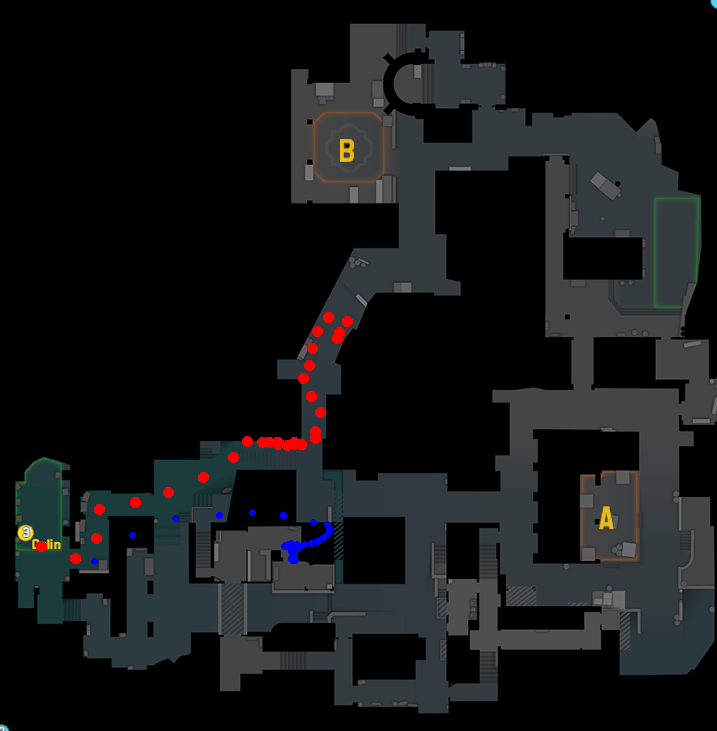

Batches iteration:   0%|          | 1/1308 [00:49<18:03:03, 49.72s/it]


KeyboardInterrupt: 

In [10]:
model = TrajPredictor().to('cuda')
model.load_checkpoint("G:\DemoAI\checkpoints\_epoch_20.pth")
model.eval()

found = False
for batch in tqdm(test_dataloader, desc="Batches iteration"):
    if isinstance(batch, (tuple, list)):
        inputs = batch[0]
    elif isinstance(batch, dict):
        inputs = batch['input']
    else:
        inputs = batch
   
    for i in range(inputs.shape[0]):
        arr = inputs[i]
       
        if hasattr(arr, 'cpu'):
            arr = arr.cpu().numpy()
       
        mask = ~(np.all(arr == 0, axis=1))
        filtered = arr[mask]
       
        if filtered.shape[0] > 50 and 7 == int(filtered[-1][0]):
            X = filtered[:, [3, 4]]
            pairs = [tuple(row) for row in X.tolist()]
            metadata = batch['metadata']
            if metadata['game'][i] != '1-5adf10e8-f556-4c08-8017-b0f64c857e46-1-1':
                continue
            
            print(f"Player {metadata['player'][i]} Game {metadata['game'][i]} {metadata['team'][i]} Round num {filtered[-1][1]}")
            
            # Инференс с окнами
            predictions = []
            current_sequence = filtered.copy()  # Копия исходной последовательности
            
            for j in range(1, len(filtered) + 1):
                window = np.zeros((128, filtered.shape[1]))
                seq_len = min(j, 128)
                window[-seq_len:] = current_sequence[j-seq_len:j]
                
                with torch.no_grad():
                    window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to('cuda')
                    pred = model(window_tensor)
                    pred_coords = pred.cpu().numpy()[0][:2]
                    predictions.append(tuple(pred_coords))
                    
                    # После первого предсказания заменяем следующие реальные точки на предсказанные
                    if j < len(filtered):
                        # Создаем новую строку с предсказанными координатами
                        next_row = current_sequence[j].copy()
                        next_row[3], next_row[4] = pred_coords[0], pred_coords[1]
                        current_sequence[j] = next_row
                        
            draw_progressive_inferno(pairs, predictions)
           
           # Отображаем оригинальные точки красным, предсказания синим
           
            found = True
            break
   
    if found:
        break